In [22]:
#Checking for memory leaks
import objgraph
objgraph.show_growth(limit=3) 

list       166429    +13565
function    49502     +6826
dict        59919     +4751


In [23]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [24]:
import os
path_to_testdata = ''
trialfilename ='MNIST_Hyperopt_More.trial'
trialfile = os.path.join(path_to_testdata,trialfilename)

In [25]:
import tensorflow as tf
import pickle
from IPython.display import clear_output 
import time

In [26]:
mnist = tf.keras.datasets.mnist

In [27]:
(x_train,y_train),(x_test,y_test)= mnist.load_data()


In [28]:
def reset_weights(model):
    session = tf.keras.backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [29]:
def train(learning_rate=0.01,mom=0.0, decay_rate=0.0,num_epochs = 1 ,n1 = 10 , n2=10, d_rate = 0.2, loss_f='sparse_categorical_crossentropy'):
    #print("Start training")
    #tstart = time.time()
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(n1,input_shape=(None,784),activation=tf.nn.relu),
        tf.keras.layers.Dropout(d_rate),
        tf.keras.layers.Dense(n2,activation=tf.nn.relu),
        tf.keras.layers.Dropout(d_rate),
        tf.keras.layers.Dense(10,activation=tf.nn.softmax)    
    ])
    #tcreate = time.time()
    #print("Model created: dt=",tcreate-tstart)
    sgd = tf.keras.optimizers.SGD(lr=learning_rate, momentum=mom, decay=decay_rate)
    #tcreateOpt = time.time()
    #print("Optimizer created: dt=",tcreateOpt-tcreate)
    model.compile(optimizer=sgd,
                  loss=loss_f,
                  metrics=['accuracy'],
                  verbose=0
    )
    #tcompile = time.time()
    #print("Model compiled: dt=",tcompile-tcreateOpt)
    model.fit(x_train,y_train,epochs=num_epochs)
    
    #tfit = time.time()
    #print("Model fitted: dt=",tfit-tcompile)
    #print("Time per epoch: ", (tfit-tcompile) / num_epochs)
    #history_callback = model.fit(x_train,y_train,epochs=num_epochs)
    #loss_history = history_callback.history["loss"]
    
    #reset_weights(model)
    
    return model

In [30]:
def load_trials():
    try:
        trials = pickle.load( open( trialfile, "rb" ) )
        print("Trials file found with", len(trials),"entries")
        if len(trials) == 0:
            trials = Trials()
    except:
        trials = Trials()
        print("No trials found. Create new trials file")

    return trials
def save_trials():
    tstart = time.time()
    pickle.dump(trials,open(trialfile, 'wb'))
    print("Saved", len(trials), "runs in ",time.time()-tstart )

In [31]:

#Used for parameter optimization
from hyperopt import fmin, tpe, space_eval
from hyperopt import hp , Trials, STATUS_OK
from hyperopt import anneal, rand, tpe, mix
from functools import partial

In [32]:
space = {'learning_rate': hp.uniform('learning_rate',0.0001,0.2), \
         'mom' : hp.uniform('mom',0.,1.), \
         'decay_rate':hp.uniform('decay_rate',0.,1.),\
         'loss_f' : hp.choice('loss_f',['sparse_categorical_crossentropy']), \
         'num_epochs' : hp.uniform('num_epochs',1,20),\
         'n1':hp.uniform('n1',5,200), \
         'n2':hp.uniform('n2',5,200), \
         'd_rate':hp.uniform('d_rate',0,1.)
        }
mix_algo = partial(mix.suggest, p_suggest=[
    (0.05, rand.suggest),
    (0.75, tpe.suggest),
    (0.20, anneal.suggest)])

In [33]:
def objective(space):
    learning_rate = space['learning_rate']
    mom = space['mom']
    decay_rate = space['decay_rate']
    num_epochs = int(space['num_epochs'])
    loss_f = space['loss_f']
    n1 = int(space['n1'])
    n2 = int(space['n2'])
    d_rate = space['d_rate']
    for i in space:
      print(i,space[i],end=';')
    print()
    model = train(learning_rate= learning_rate,mom=mom, decay_rate=decay_rate,num_epochs=num_epochs,loss_f=loss_f, n1 = n1 , n2=n2,d_rate= d_rate)
    score, acc = model.evaluate(x_test,y_test)
    #print("Clear session...") 
    tf.keras.backend.clear_session() #There is a memory leak in some tensorflow sessions
    return {
        'loss' : -1*acc,
        'status' : STATUS_OK,
        'eval_time': time.time(),
    }
    

In [34]:
best = [0]
trials = load_trials()

try:
        while True:
            max_trials = len(trials)+1
            %memit best.append(fmin(objective, space, algo=mix_algo, max_evals=max_trials, trials=trials))
            if max_trials % 3 == 0:
                clear_output()
                print("#### Did number:", max_trials)
                save_trials()
                print("Memory growth:")
                objgraph.show_growth(limit=3) 

            

except KeyboardInterrupt:
    print("Analysis done...")
    save_trials()
best = best[-1]

#### Did number: 12555
Saved 12555 runs in  0.18099641799926758
Memory growth:
list   225760       +48
dict    74797       +12
d_rate 0.9475731707483687;decay_rate 0.018295403826764665;learning_rate 0.004610704611258358;loss_f sparse_categorical_crossentropy;mom 0.27013517343704274;n1 174.91900118062597;n2 179.60734643227838;num_epochs 6.42044567334081;
Epoch 1/6
60000/60000 [==============================] - 4s 65us/step - loss: 8.9128 - acc: 0.4412
Epoch 2/6
60000/60000 [==============================] - 4s 61us/step - loss: 5.7400 - acc: 0.6324
Epoch 3/6
60000/60000 [==============================] - 4s 60us/step - loss: 4.3153 - acc: 0.7201
Epoch 4/6
60000/60000 [==============================] - 4s 64us/step - loss: 3.5516 - acc: 0.7663: 0s - loss: 3.5556 - acc: 0.76
Epoch 5/6
60000/60000 [==============================] - 4s 65us/step - loss: 2.7519 - acc: 0.8167
Epoch 6/6
10000/10000 [==============================] - 0s 36us/step
peak memory: 506.56 MiB, increment: 8.09 MiB
d_r

Process MemTimer-4186:
Traceback (most recent call last):


Analysis done...


  File "/home/markstein/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/markstein/.pyenv/versions/3.6.6/envs/dev/lib/python3.6/site-packages/memory_profiler.py", line 233, in run
    stop = self.pipe.poll(self.interval)
  File "/home/markstein/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/markstein/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/markstein/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/home/markstein/.pyenv/versions/3.6.6/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt


Saved 12558 runs in  0.2030811309814453


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [36]:
lst = []
all = []
for x in trials.trials: 
    if x['result']['status']=='ok':
        for y in x['misc']['vals']:
            lst.append(x['misc']['vals'][y][0])
        lst.append(x['result']['loss'])
    all.append(lst)
    lst = []

In [37]:
best

{'d_rate': 0.9963018165741212,
 'decay_rate': 0.00016373656491834398,
 'learning_rate': 0.0007693133167426016,
 'loss_f': 0,
 'mom': 0.33403565500079835,
 'n1': 166.2337306783661,
 'n2': 185.65791010478256,
 'num_epochs': 5.539668526244144}

In [38]:
pd_trials = pd.DataFrame(all)
pd_trials.columns = ['d_rate','decay_rate','learning_rate','loss_f','mom','n1','n2','num_epochs','loss']
pd_trials['loss_f'] = pd_trials['loss_f'].apply(lambda x : 'sparse_categorical_crossentropy' if x ==0 else 'other' )
pd_trials = pd_trials.dropna()
pd_trials.sample(1)

,d_rate,decay_rate,learning_rate,loss_f,mom,n1,n2,num_epochs,loss
2656,0.961425,0.070958,0.005549,sparse_categorical_crossentropy,0.233899,142.677361,194.62828,7.043304,-0.101


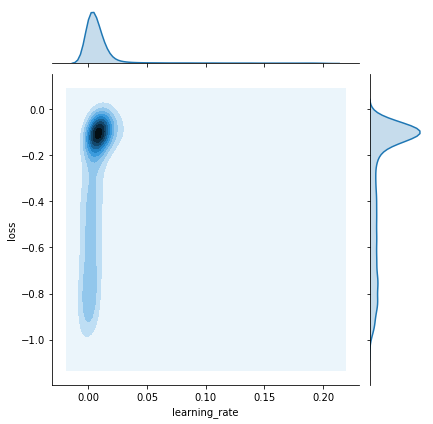

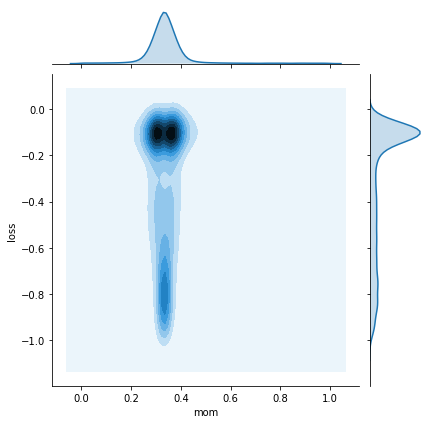

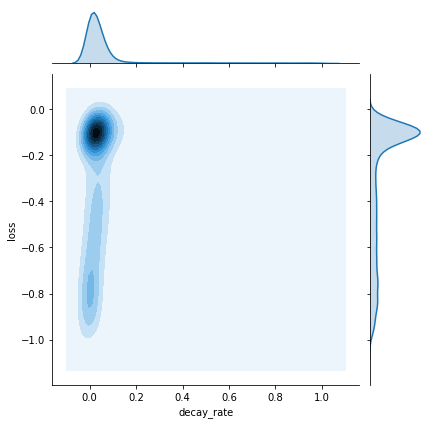

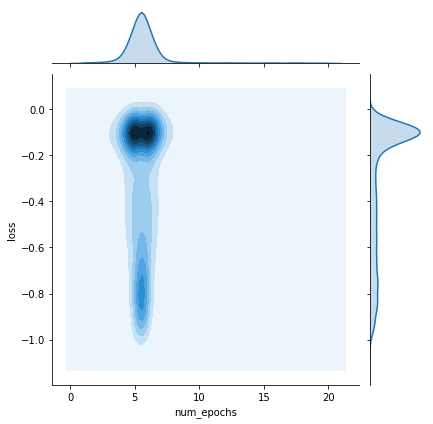

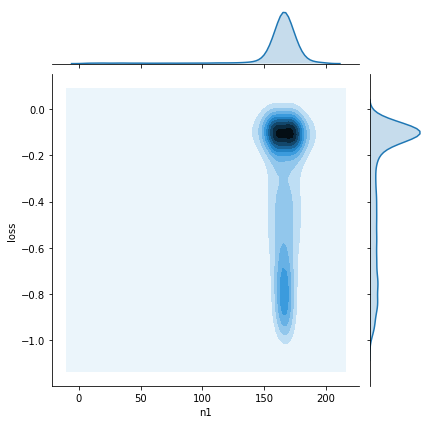

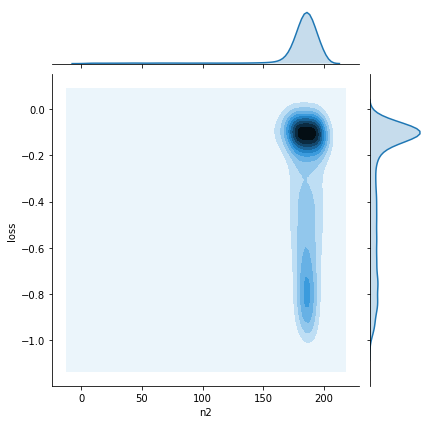

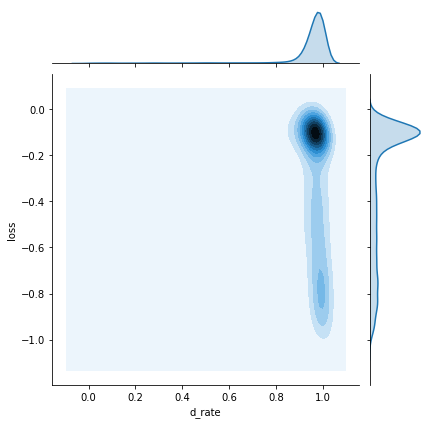

In [39]:
sns.jointplot("learning_rate", "loss", data=pd_trials, kind='kde' )
sns.jointplot("mom", "loss", data=pd_trials, kind='kde')
sns.jointplot("decay_rate", "loss", data=pd_trials, kind='kde')
sns.jointplot("num_epochs", "loss", data=pd_trials, kind='kde')
sns.jointplot("n1", "loss", data=pd_trials, kind='kde')
sns.jointplot("n2", "loss", data=pd_trials, kind='kde')
sns.jointplot("d_rate", "loss", data=pd_trials, kind='kde')

In [40]:
space_eval(space,best)

{'d_rate': 0.9963018165741212,
 'decay_rate': 0.00016373656491834398,
 'learning_rate': 0.0007693133167426016,
 'loss_f': 'sparse_categorical_crossentropy',
 'mom': 0.33403565500079835,
 'n1': 166.2337306783661,
 'n2': 185.65791010478256,
 'num_epochs': 5.539668526244144}

In [41]:
objective(space_eval(space,best))

d_rate 0.9963018165741212;decay_rate 0.00016373656491834398;learning_rate 0.0007693133167426016;loss_f sparse_categorical_crossentropy;mom 0.33403565500079835;n1 166.2337306783661;n2 185.65791010478256;num_epochs 5.539668526244144;
Epoch 1/5
60000/60000 [==============================] - 4s 72us/step - loss: 7.6441 - acc: 0.5208
Epoch 2/5
60000/60000 [==============================] - 4s 63us/step - loss: 4.2981 - acc: 0.7276
Epoch 3/5
60000/60000 [==============================] - 4s 59us/step - loss: 2.0374 - acc: 0.8651
Epoch 4/5
60000/60000 [==============================] - 4s 63us/step - loss: 1.0243 - acc: 0.9285
Epoch 5/5
10000/10000 [==============================] - 0s 30us/step


{'loss': -0.9463, 'status': 'ok', 'eval_time': 1548705235.4989517}

In [42]:
pd_trials[pd_trials['loss']<-0.955]

,d_rate,decay_rate,learning_rate,loss_f,mom,n1,n2,num_epochs,loss
5872,0.995542,0.000584,0.000909,sparse_categorical_crossentropy,0.333882,166.386438,185.704325,5.526373,-0.9556
8114,0.996544,0.000135,0.000787,sparse_categorical_crossentropy,0.333718,166.234430,185.762729,5.543043,-0.9557
8645,0.997077,0.000119,0.000753,sparse_categorical_crossentropy,0.333829,166.295935,185.658913,5.535316,-0.9556
8866,0.997362,0.000180,0.000843,sparse_categorical_crossentropy,0.333727,166.250125,185.578048,5.530749,-0.9557
8974,0.996302,0.000164,0.000769,sparse_categorical_crossentropy,0.334036,166.233731,185.657910,5.539669,-0.9563
